In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import folium
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [123]:
# importing data

schools = pd.read_csv(".\education_analytics\Masterlist of Schools.csv", index_col="school.id")

school_locs = pd.read_csv(".\education_analytics\Schools Location Data.csv", 
                          encoding = "latin-1", 
                          index_col="School ID",
                          usecols=["School ID", "Enrolment", "Latitude", "Longitude"])

rooms = pd.read_csv('.\education_analytics\Rooms data.csv', index_col="School ID")

teachers = pd.read_csv(".\education_analytics\Teachers data.csv", index_col="school.id")

"""
primary = pd.read_csv(".\education_analytics\Enrollment Master Data_2015_E.csv")[:-1].astype(int).set_index("School ID")

secondary = (pd.read_csv('.\education_analytics\Enrollment Master Data_2015_S.csv')[:-1]
                  .replace(",", "", regex=True)
                  .astype(int)
                  .replace("SPED NG Male", "SPED NG Male SS")
                  .replace("SPED NG Female", "SPED NG Female SS")
                  .set_index("School ID"))*/
"""

mooe = (pd.read_csv('.\education_analytics\MOOE data.csv', index_col="school.id", usecols=["school.id", " school.mooe "])
             .replace(",", "", regex=True).astype(float))

schools_boncodin = pd.read_csv("schools_boncodin.csv")
urbanity = pd.read_csv("Regional_Urbanity.csv")
lit_rate = pd.read_csv("Regional_Functional_Literacy_Rate_2015.csv")
st_ratio = pd.read_csv("stratio.csv")
nep = pd.read_csv("nep-1519.csv")

In [124]:
schools_master = pd.concat([schools, school_locs, rooms, teachers, mooe], axis=1)
schools_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46751 entries, 100001 to 900279
Data columns (total 34 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   school.name                 46603 non-null  object 
 1   school.region               46603 non-null  object 
 2   school.region.name          46603 non-null  object 
 3   school.province             46603 non-null  object 
 4   school.cityhall             46602 non-null  object 
 5   school.division             46603 non-null  object 
 6   school.citymuni             46603 non-null  object 
 7   school.district             46603 non-null  object 
 8   school.legdistrict          46603 non-null  object 
 9   school.type                 46603 non-null  object 
 10  school.abbrev               18167 non-null  object 
 11  school.previousname         42221 non-null  object 
 12  school.mother.id            46596 non-null  float64
 13  school.address           

In [125]:
#import Boncodin MOOE data for all schools

schools_boncodin['mooe_diff'] = schools_boncodin[' school.mooe '] - schools_boncodin['boncodin_mooe']
schools_boncodin['percent_diff'] = schools_boncodin['mooe_diff'] / schools_boncodin[' school.mooe ']


In [126]:
#importing urbanity, literacy rate, and regional data

region_mooe = schools_boncodin.groupby("school.region")[[" school.mooe ","boncodin_mooe","mooe_diff"]].agg(np.sum)
ppr = schools_boncodin.groupby("school.region")["percent_diff"].agg(np.mean)

region_data = pd.concat([region_mooe, ppr], axis=1)
region_data = pd.merge(region_data, urbanity, left_on=region_data.index, right_on="Region", how="outer")
region_data = pd.merge(region_data, lit_rate, left_on="Region", right_on="Region", how="outer")
#region_data

In [127]:
#importing shapefile
shapefile = gpd.read_file('./Regions/Regions.shp')
shapefile.head()


,REGION,geometry
0,Autonomous Region of Muslim Mindanao (ARMM),"MULTIPOLYGON (((119.46694 4.58694, 119.46639 4..."
1,Bicol Region (Region V),"MULTIPOLYGON (((122.98417 11.71056, 122.98333 ..."
2,CALABARZON (Region IV-A),"MULTIPOLYGON (((125.22166 10.43444, 125.22195 ..."
3,Cagayan Valley (Region II),"MULTIPOLYGON (((122.47040 16.91995, 122.47040 ..."
4,Caraga (Region XIII),"MULTIPOLYGON (((126.41750 7.96417, 126.41778 7..."


In [128]:
#replace roman numerals in region names
schools_master.replace({'school.region' : {'Autonomous Region of Muslim Mindanao (ARMM)': 'ARMM', 
                                           'Region V' : 'Region 05', 
                                           'Region IV-A' : 'Region 04A', 
                                           'Region II' : 'Region 02', 
                                           'Region XIII' : 'CARAGA', 
                                           'Region III' : 'Region 03', 
                                           'Region VII' : 'Region 07', 
                                           'Cordillera Administrative Region (CAR)' : 'CAR', 
                                           'Region XI' : 'Region 11', 
                                           'Region VIII' : 'Region 08', 
                                           'Region I' : 'Region 01', 
                                           'Region IV-B' : 'Region 04B', 
                                           'Metropolitan Manila' : 'NCR', 
                                           'Region X' : 'Region 10', 
                                           'Region XII' : 'Region 12', 
                                           'Region VI' : 'Region 06', 
                                           'Region IX' : 'Region 09'}}, inplace=True)
schools_master['school.region'].unique()

array(['Region 01', 'Region 02', nan, 'Region 03', 'Region 04A',
       'Region 04B', 'Region 05', 'Region 06', 'Region 07', 'Region 08',
       'Region 09', 'Region 10', 'Region 11', 'Region 12', 'CARAGA',
       'ARMM', 'CAR', 'NCR'], dtype=object)

In [129]:
#replace city income values
city_income_corrections={
    "P 25 M or more but less than P 35 M":30000000,
    "P 35 M or more but less than P 45 M":40000000,
    "P 15 M or more but less than P 25 M":20000000,
    "P 45 M or more but less than P 55 M":50000000,
    "P 160 M or more but less than P 240 M":200000000,
    "P 240 M or more but less than P 320 M":280000000,
    "P 55 M or more":55000000,
    "P 320 M or more but less than P 400 M":360000000,
    "P 400 M or more":400000000,
    "Below P 15 M":15000000,
    "P 80 M or more but less than P 160 M":120000000
}

incorrect_city_income_format = list(city_income_corrections.keys())

def assign_city_income(x):
  if x["school.cityincome"] in incorrect_city_income_format:
    corrected_city_income=city_income_corrections[x["school.cityincome"]]
    x["school.cityincome"]=corrected_city_income

  return x

schools_master = schools_master.apply(lambda x: assign_city_income(x), axis=1)


schools_master.dropna()
schools_master = schools_master[schools_master["school.cityincome"] != "Special Class"]

schools_master

,school.name,school.region,school.region.name,school.province,school.cityhall,school.division,school.citymuni,school.district,school.legdistrict,school.type,school.abbrev,school.previousname,school.mother.id,school.address,school.established,school.classification,school.classification2,school.curricularclass,school.organization,school.cityincome,school.cityclass,school.urban,Enrolment,Latitude,Longitude,rooms.standard.academic,rooms.standard.unused,rooms.nonstandard.academic,rooms.nonstandard.unused,teachers.instructor,teachers.mobile,teachers.regular,teachers.sped,school.mooe
100001,Apaleng-Libtong ES,Region 01,Ilocos Region,ILOCOS NORTE,ILOCOS NORTE,Ilocos Norte,BACARRA,Bacarra I,1st District,School with no Annexes,NaN,Apaleng-Libtong PS,100001.0,-,1/1/1996,Elementary,DepED Managed,Kinder & Elementary,Combined Monograde and Multigrade,40000000,NaN,Partially Urban,90.0,18.253666,120.606180,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,84000.0
100002,Bacarra CES,Region 01,Ilocos Region,ILOCOS NORTE,ILOCOS NORTE,Ilocos Norte,BACARRA,Bacarra I,1st District,School with no Annexes,NaN,-,100002.0,Santa Rita,1/1/1914,Elementary,DepED Managed,Elementary,Monograde,40000000,NaN,Partially Urban,456.0,18.250964,120.608958,12.0,0.0,0.0,0.0,0.0,6.0,11.0,0.0,268000.0
100003,Buyon ES,Region 01,Ilocos Region,ILOCOS NORTE,ILOCOS NORTE,Ilocos Norte,BACARRA,Bacarra I,1st District,School with no Annexes,NaN,-,100003.0,NONE,1/1/1947,Elementary,DepED Managed,Elementary,Monograde,40000000,NaN,Partially Urban,167.0,18.234599,120.616037,6.0,0.0,0.0,0.0,0.0,1.0,6.0,0.0,135000.0
100004,Ganagan ES,Region 01,Ilocos Region,ILOCOS NORTE,ILOCOS NORTE,Ilocos Norte,BACARRA,Bacarra I,1st District,School with no Annexes,NaN,NaN,100004.0,NONE,1/1/1949,Elementary,DepED Managed,Elementary,Monograde,40000000,NaN,Partially Urban,122.0,18.250014,120.587169,6.0,0.0,0.0,0.0,0.0,1.0,6.0,0.0,116000.0
100005,Macupit ES,Region 01,Ilocos Region,ILOCOS NORTE,ILOCOS NORTE,Ilocos Norte,BACARRA,Bacarra I,1st District,School with no Annexes,NaN,-,100005.0,Macupit,1/1/1913,Elementary,DepED Managed,Elementary,Monograde,40000000,NaN,Partially Urban,77.0,18.293994,120.641019,6.0,0.0,0.0,0.0,0.0,1.0,6.0,0.0,115000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326101,Upper Katungal National High School-TNHS Annex,Region 12,Soccsksargen,SULTAN KUDARAT,SULTAN KUDARAT,Tacurong City,CITY OF TACURONG,Tacurong South,1st District,Annex or Extension school(s),UKNHS-TNHS Annex,Tacurong NHS - Upper Katungal Annex,304624.0,Upper Katungal,1/1/2011,Secondary,DepED Managed,Secondary,Monograde,200000000,Component City,Partially Urban,262.0,6.649561,124.660667,2.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,174000.0
326102,San Emmanuel National High School-Annex,Region 12,Soccsksargen,SULTAN KUDARAT,SULTAN KUDARAT,Tacurong City,CITY OF TACURONG,Tacurong East,1st District,Annex or Extension school(s),SENHS-Annex,NaN,304622.0,"Purok San Jose, San Pablo, Tacurong City",1/1/2012,Secondary,DepED Managed,Secondary,Monograde,200000000,Component City,Partially Urban,191.0,6.697856,124.701979,2.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,144000.0
326501,Sulon National High School,ARMM,Autonomous Region in Muslim Mindanao,MAGUINDANAO,MAGUINDANAO,Maguindanao II,SULTAN MASTURA,Sultan Mastura,1st District,School with no Annexes,NaN,NaN,326501.0,Brgy. Sulon,1/26/1968,Secondary,DepED Managed,Secondary,Monograde,20000000,NaN,Partially Urban,185.0,0.000000,0.000000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN
356059,Ocana National High School (Kalangyawon Extens...,Region 07,Central Visayas,CEBU,CEBU,Carcar City,CITY OF CARCAR,Carcar II,1st District,Annex or Extension school(s),ONHS-Ext,-n.a,303066.0,"Kalangyawon, Napo",1/1/2009,Secondary,DepED Managed,Secondary,Monograde,NaN,Component City,Partially Urban,136.0,10.067247,123.627106,3.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,177000.0


In [130]:
#isolate numerical data
schools_num = schools_master[['school.region', 'school.province', 'school.cityincome', 'school.classification', 'rooms.standard.academic', 'rooms.standard.unused',
       'rooms.nonstandard.academic', 'rooms.nonstandard.unused',
       'teachers.instructor', 'teachers.mobile', 'teachers.regular',
       'teachers.sped','Enrolment', ' school.mooe ']].reset_index()

schools_num["rooms_total"] = (schools_num['rooms.standard.academic'] + 
                             schools_num['rooms.standard.unused'] + 
                             schools_num['rooms.nonstandard.academic'] + 
                             schools_num['rooms.nonstandard.unused'])

schools_num["teachers_total"] = (schools_num['teachers.instructor'] + 
                             schools_num['teachers.mobile'] + 
                             schools_num['teachers.regular'] + 
                             schools_num['teachers.sped'])
schools_num

,index,school.region,school.province,school.cityincome,school.classification,rooms.standard.academic,rooms.standard.unused,rooms.nonstandard.academic,rooms.nonstandard.unused,teachers.instructor,teachers.mobile,teachers.regular,teachers.sped,Enrolment,school.mooe,rooms_total,teachers_total
0,100001,Region 01,ILOCOS NORTE,40000000,Elementary,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,90.0,84000.0,2.0,2.0
1,100002,Region 01,ILOCOS NORTE,40000000,Elementary,12.0,0.0,0.0,0.0,0.0,6.0,11.0,0.0,456.0,268000.0,12.0,17.0
2,100003,Region 01,ILOCOS NORTE,40000000,Elementary,6.0,0.0,0.0,0.0,0.0,1.0,6.0,0.0,167.0,135000.0,6.0,7.0
3,100004,Region 01,ILOCOS NORTE,40000000,Elementary,6.0,0.0,0.0,0.0,0.0,1.0,6.0,0.0,122.0,116000.0,6.0,7.0
4,100005,Region 01,ILOCOS NORTE,40000000,Elementary,6.0,0.0,0.0,0.0,0.0,1.0,6.0,0.0,77.0,115000.0,6.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46601,326101,Region 12,SULTAN KUDARAT,200000000,Secondary,2.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,262.0,174000.0,2.0,NaN
46602,326102,Region 12,SULTAN KUDARAT,200000000,Secondary,2.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,191.0,144000.0,2.0,NaN
46603,326501,ARMM,MAGUINDANAO,20000000,Secondary,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,185.0,NaN,NaN,0.0
46604,356059,Region 07,CEBU,NaN,Secondary,3.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,136.0,177000.0,3.0,NaN


In [131]:
schools_num.isna().sum()

index                            0
school.region                  148
school.province                148
school.cityincome             1124
school.classification          148
rooms.standard.academic        339
rooms.standard.unused          339
rooms.nonstandard.academic     343
rooms.nonstandard.unused       343
teachers.instructor           1710
teachers.mobile               1710
teachers.regular              1710
teachers.sped                 1710
Enrolment                      127
 school.mooe                  2723
rooms_total                    343
teachers_total                1710
dtype: int64

In [132]:
#data cleaning
schools_num_clean = schools_num.dropna()
print(schools_num_clean.shape)
schools_num_clean.info()

(41426, 17)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 41426 entries, 0 to 46596
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   index                       41426 non-null  int64  
 1   school.region               41426 non-null  object 
 2   school.province             41426 non-null  object 
 3   school.cityincome           41426 non-null  object 
 4   school.classification       41426 non-null  object 
 5   rooms.standard.academic     41426 non-null  float64
 6   rooms.standard.unused       41426 non-null  float64
 7   rooms.nonstandard.academic  41426 non-null  float64
 8   rooms.nonstandard.unused    41426 non-null  float64
 9   teachers.instructor         41426 non-null  float64
 10  teachers.mobile             41426 non-null  float64
 11  teachers.regular            41426 non-null  float64
 12  teachers.sped               41426 non-null  float64
 13  Enrolment          

In [133]:
df_enrollment_final = schools_num_clean.groupby(["school.province"])[["school.cityincome", "Enrolment"]].apply(lambda x : x.sum())
df_enrollment_final.columns = ['Schools_Income', 'Schools_Enrollment']
df_enrollment_final

,Schools_Income,Schools_Enrollment
school.province,,
ABRA,7615000000,48157.0
AGUSAN DEL NORTE,64250000000,148055.0
AGUSAN DEL SUR,42980000000,180966.0
AKLAN,13265000000,117363.0
ALBAY,67485000000,327515.0
ANTIQUE,20125000000,136743.0
APAYAO,8000000000,26123.0
AURORA,7510000000,51979.0
BATAAN,13590000000,150792.0


In [134]:
df_rooms_final = schools_num_clean.groupby(["school.province"])[["school.cityincome", "rooms_total"]].apply(lambda x : x.sum())
df_rooms_final.columns = ['Schools_Income', 'Schools_Rooms']
df_rooms_final

,Schools_Income,Schools_Rooms
school.province,,
ABRA,7615000000,1663.0
AGUSAN DEL NORTE,64250000000,2802.0
AGUSAN DEL SUR,42980000000,3566.0
AKLAN,13265000000,3084.0
ALBAY,67485000000,7704.0
ANTIQUE,20125000000,3513.0
APAYAO,8000000000,815.0
AURORA,7510000000,1335.0
BATAAN,13590000000,3357.0


In [135]:
# Get indexes where name column doesn't have value 
indexNames = schools_num_clean[(schools_num_clean['school.cityincome'] == 'Special Class')].index 
# Delete these row indexes from dataFrame
schools_num_clean.drop(indexNames, inplace=True)



df_teachers = schools_num_clean.groupby(["school.province"])[["school.cityincome", "teachers_total"]].apply(lambda x : x.sum())
df_teachers.columns = ['Schools_Income', 'Schools_Teachers']

df_teachers

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,Schools_Income,Schools_Teachers
school.province,,
ABRA,7615000000,1902.0
AGUSAN DEL NORTE,64250000000,3838.0
AGUSAN DEL SUR,42980000000,4314.0
AKLAN,13265000000,3742.0
ALBAY,67485000000,9035.0
ANTIQUE,20125000000,4395.0
APAYAO,8000000000,899.0
AURORA,7510000000,1458.0
BATAAN,13590000000,3812.0


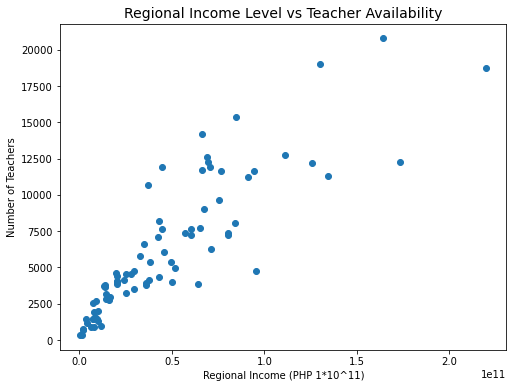

In [136]:
plt.figure(figsize=(8,6))
plt.scatter(df_teachers["Schools_Income"], df_teachers["Schools_Teachers"])
plt.title("Regional Income Level vs Teacher Availability", fontsize=14)
plt.ylabel("Number of Teachers")
plt.xlabel("Regional Income (PHP 1*10^11)")
plt.show()
#df_final["ratio"] = df_final["total_teachers"]/df_final["school.cityincome"]

#df_final.plot.bar(stacked=True)


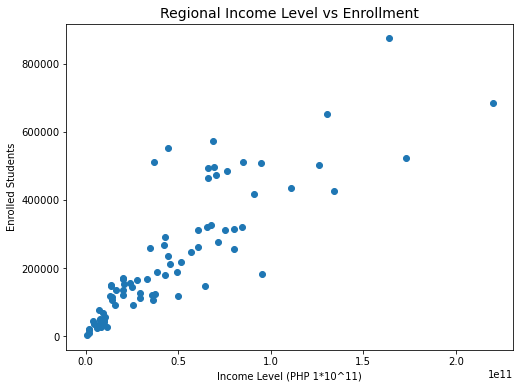

In [137]:
plt.figure(figsize=(8,6))
plt.scatter(df_enrollment_final["Schools_Income"], df_enrollment_final["Schools_Enrollment"])
plt.title("Regional Income Level vs Enrollment", fontsize=14)
plt.ylabel("Enrolled Students")
plt.xlabel("Income Level (PHP 1*10^11)")
plt.show()

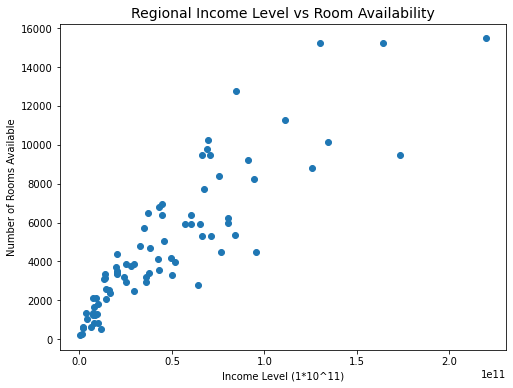

In [138]:
plt.figure(figsize=(8,6))
plt.scatter(df_rooms_final["Schools_Income"], df_rooms_final["Schools_Rooms"])
plt.title("Regional Income Level vs Room Availability", fontsize=14)
plt.ylabel("Number of Rooms Available")
plt.xlabel("Income Level (1*10^11)")
plt.show()

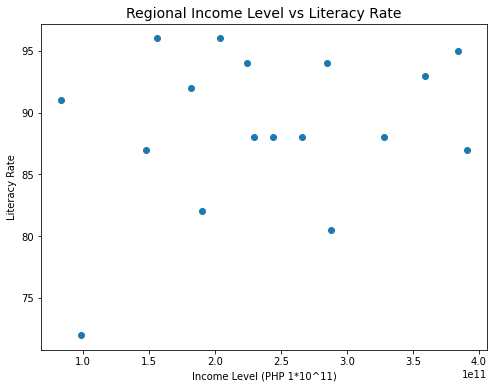

,literacy_rate,school.cityincome
literacy_rate,1.000000,0.242757
school.cityincome,0.242757,1.000000


In [139]:
plt.figure(figsize=(8,6))
plt.scatter(lit_rate["school.cityincome"], lit_rate["literacy_rate"])
plt.title("Regional Income Level vs Literacy Rate", fontsize=14)
plt.ylabel("Literacy Rate")
plt.xlabel("Income Level (PHP 1*10^11)")
plt.show()
lit_rate.corr()

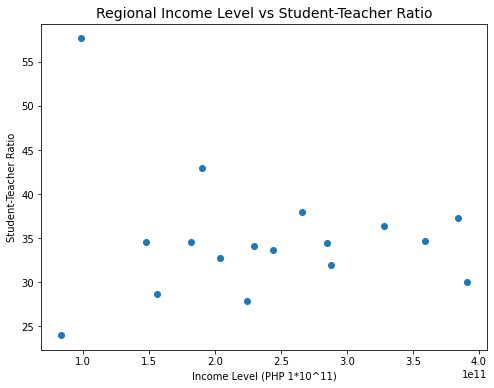

,student_teacher_ratio,school.cityincome
student_teacher_ratio,1.000000,-0.141581
school.cityincome,-0.141581,1.000000


In [140]:
plt.figure(figsize=(8,6))
plt.scatter(st_ratio["school.cityincome"], st_ratio["student_teacher_ratio"])
plt.title("Regional Income Level vs Student-Teacher Ratio", fontsize=14)
plt.ylabel("Student-Teacher Ratio")
plt.xlabel("Income Level (PHP 1*10^11)")
plt.show()
st_ratio.corr()

In [141]:
merged_df = pd.merge(df_enrollment_final, df_rooms_final, on="Schools_Income")
merged_df.columns = ['Schools_Income', 'Schools_Enrollment', 'Schools_Rooms']


#df_enrollment_final.columns = ['Schools_Income', 'Schools_Enrollment']

merged_df_2 = pd.merge(merged_df, df_teachers, on="Schools_Income")
merged_df_2.columns = ['Schools_Income', 'Schools_Enrollment', 'Schools_Rooms', 'Schools_Teachers']

merged_df_2

merged_df_2.corr()

,Schools_Income,Schools_Enrollment,Schools_Rooms,Schools_Teachers
Schools_Income,1.000000,0.858895,0.884988,0.873014
Schools_Enrollment,0.858895,1.000000,0.936321,0.984545
Schools_Rooms,0.884988,0.936321,1.000000,0.963184
Schools_Teachers,0.873014,0.984545,0.963184,1.000000


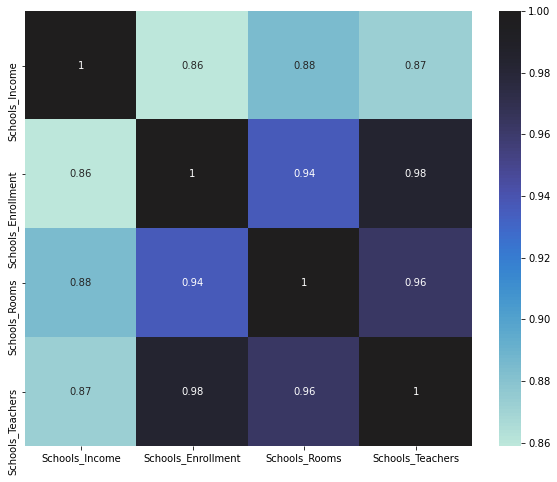

In [142]:
plt.figure(figsize=(10,8))

sns.heatmap(merged_df_2.corr(), center=1, annot=True)

plt.show()

In [143]:
schools_boncodin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42342 entries, 0 to 42341
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   index                       42342 non-null  int64  
 1   school.region               42342 non-null  object 
 2   school.classification       42342 non-null  object 
 3   rooms.standard.academic     42342 non-null  int64  
 4   rooms.standard.unused       42342 non-null  int64  
 5   rooms.nonstandard.academic  42342 non-null  int64  
 6   rooms.nonstandard.unused    42342 non-null  int64  
 7   teachers.instructor         42342 non-null  int64  
 8   teachers.mobile             42342 non-null  int64  
 9   teachers.regular            42342 non-null  int64  
 10  teachers.sped               42342 non-null  int64  
 11  Enrolment                   42342 non-null  int64  
 12   school.mooe                42342 non-null  int64  
 13  rooms_total                 423

In [144]:
# Check region
print('schools df:\n', sorted(schools_boncodin["school.region"].unique()), '\n')
print('shapefile df:\n', sorted(shapefile["REGION"].unique()))

schools df:
 ['CAR', 'CARAGA', 'NCR', 'Region 01', 'Region 02', 'Region 03', 'Region 04A', 'Region 04B', 'Region 05', 'Region 06', 'Region 07', 'Region 08', 'Region 09', 'Region 10', 'Region 11', 'Region 12'] 

shapefile df:
 ['Autonomous Region of Muslim Mindanao (ARMM)', 'Bicol Region (Region V)', 'CALABARZON (Region IV-A)', 'Cagayan Valley (Region II)', 'Caraga (Region XIII)', 'Central Luzon (Region III)', 'Central Visayas (Region VII)', 'Cordillera Administrative Region (CAR)', 'Davao Region (Region XI)', 'Eastern Visayas (Region VIII)', 'Ilocos Region (Region I)', 'MIMAROPA (Region IV-B)', 'Metropolitan Manila', 'Northern Mindanao (Region X)', 'SOCCSKSARGEN (Region XII)', 'Western Visayas (Region VI)', 'Zamboanga Peninsula (Region IX)']


In [145]:
# Replace region name
shapefile.replace({'REGION' : {'Autonomous Region of Muslim Mindanao (ARMM)': 'ARMM', 
                               'Bicol Region (Region V)' : 'Region 05', 
                               'CALABARZON (Region IV-A)' : 'Region 04A', 
                               'Cagayan Valley (Region II)' : 'Region 02', 
                               'Caraga (Region XIII)' : 'CARAGA', 
                               'Central Luzon (Region III)' : 'Region 03', 
                               'Central Visayas (Region VII)' : 'Region 07', 
                               'Cordillera Administrative Region (CAR)' : 'CAR', 
                               'Davao Region (Region XI)' : 'Region 11', 
                               'Eastern Visayas (Region VIII)' : 'Region 08', 
                               'Ilocos Region (Region I)' : 'Region 01', 
                               'MIMAROPA (Region IV-B)' : 'Region 04B', 
                               'Metropolitan Manila' : 'NCR', 
                               'Northern Mindanao (Region X)' : 'Region 10', 
                               'SOCCSKSARGEN (Region XII)' : 'Region 12', 
                               'Western Visayas (Region VI)' : 'Region 06', 
                               'Zamboanga Peninsula (Region IX)' : 'Region 09'}}, inplace=True)
print(sorted(shapefile["REGION"].unique()))

['ARMM', 'CAR', 'CARAGA', 'NCR', 'Region 01', 'Region 02', 'Region 03', 'Region 04A', 'Region 04B', 'Region 05', 'Region 06', 'Region 07', 'Region 08', 'Region 09', 'Region 10', 'Region 11', 'Region 12']


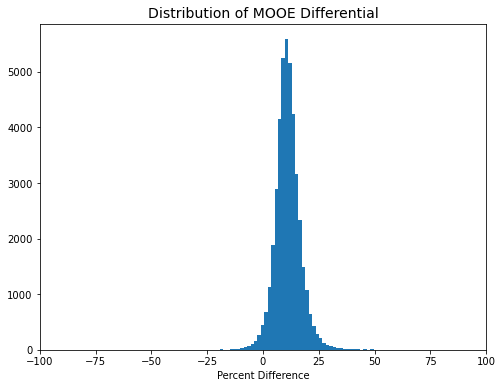

In [146]:
#distribution of percent differences
#df["student_teacher"] = df["enrollment"]/df["Total_Inst"]
#df = df.replace([np.inf, -np.inf], np.nan)

plt.figure(figsize=(8,6))
plt.hist(schools_boncodin["percent_diff"]*100, bins=100)
plt.title("Distribution of MOOE Differential", fontsize=14)
plt.xlabel("Percent Difference")
plt.xlim(-100, 100)
plt.show()

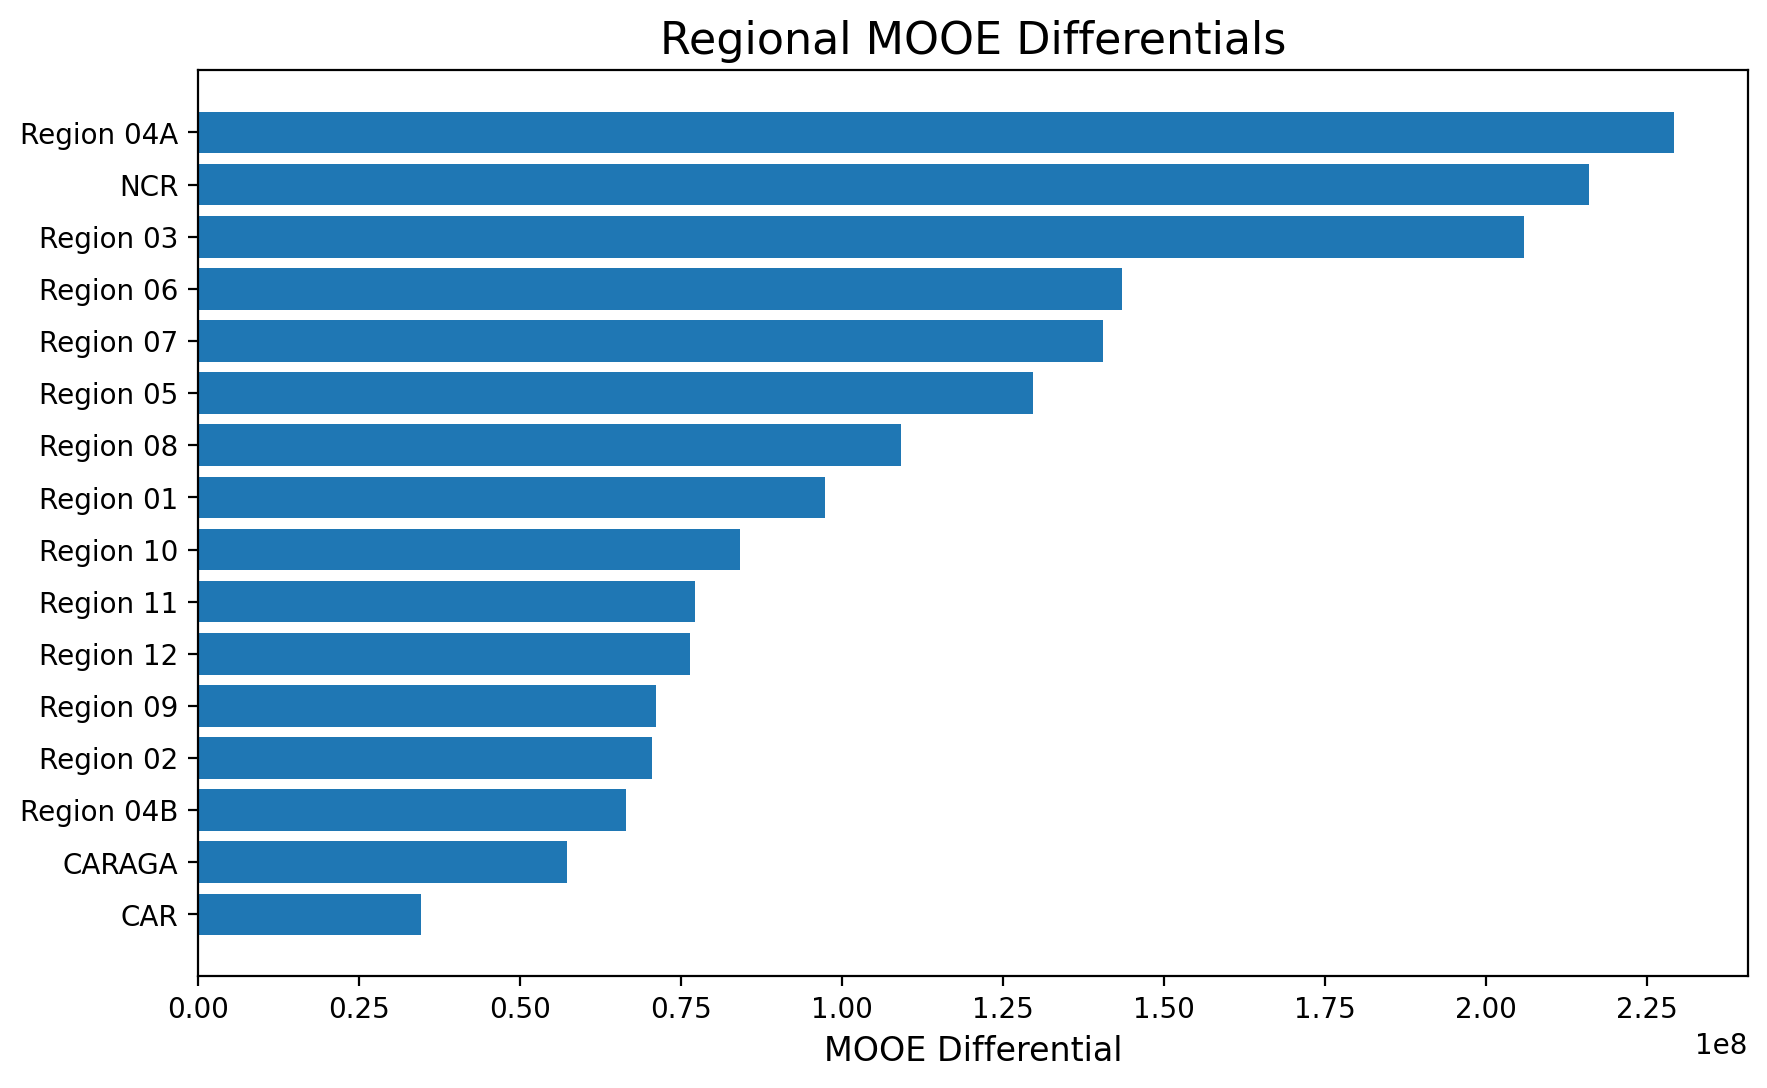

In [147]:
#plot of regional MOOE differential
mpr = schools_boncodin.groupby("school.region")["mooe_diff"].agg(np.sum).sort_values()

# indicates if plotting on the figures or on subplots
plt.figure(figsize=(10,6), dpi=200) 

# the main code to create the graph
plt.barh(mpr.index, mpr.values) 

# additional elements that can be customzed
plt.title("Regional MOOE Differentials", fontsize = 16)
plt.xlabel("MOOE Differential", fontsize=12)
plt.xticks(range(0,250000000,25000000))

# display graph
plt.show()

In [148]:
region_data[[" school.mooe ","boncodin_mooe", "mooe_diff", 'urbanity', 'literacy_rate']].corr()

,school.mooe,boncodin_mooe,mooe_diff,urbanity,literacy_rate
school.mooe,1.000000,0.998704,0.969157,0.608361,0.192762
boncodin_mooe,0.998704,1.000000,0.955356,0.574055,0.167227
mooe_diff,0.969157,0.955356,1.000000,0.751870,0.309237
urbanity,0.608361,0.574055,0.751870,1.000000,0.454457
literacy_rate,0.192762,0.167227,0.309237,0.454457,1.000000


In [150]:
merged_data = pd.merge(shapefile, mpr, left_on="REGION", right_on="school.region", how="outer")
merged_data

,REGION,geometry,mooe_diff
0,ARMM,"MULTIPOLYGON (((119.46694 4.58694, 119.46639 4...",NaN
1,Region 05,"MULTIPOLYGON (((122.98417 11.71056, 122.98333 ...",129661800.0
2,Region 04A,"MULTIPOLYGON (((125.22166 10.43444, 125.22195 ...",229248400.0
3,Region 02,"MULTIPOLYGON (((122.47040 16.91995, 122.47040 ...",70585000.0
4,CARAGA,"MULTIPOLYGON (((126.41750 7.96417, 126.41778 7...",57402200.0
5,Region 03,"MULTIPOLYGON (((120.62363 14.36788, 120.62368 ...",205910200.0
6,Region 07,"MULTIPOLYGON (((123.27111 9.08476, 123.27173 9...",140547600.0
7,CAR,"POLYGON ((121.37679 17.95473, 121.36825 17.939...",34685200.0
8,Region 11,"MULTIPOLYGON (((125.39778 5.43583, 125.39778 5...",77193000.0
9,Region 08,"MULTIPOLYGON (((125.07361 9.89472, 125.07333 9...",109267000.0


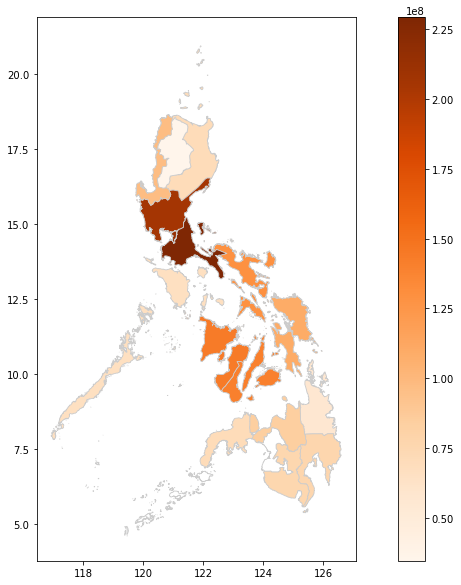

In [151]:
# set a variable that will call whatever column we want to visualise on the map
variable = 'mooe_diff'
# set the range for the choropleth
vmin, vmax = merged_data['mooe_diff'].min(), merged_data['mooe_diff'].max()
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(15, 10))

merged_data.plot(column=variable, cmap='Oranges', linewidth=0.8, ax=ax, edgecolor='0.8', vmin=vmin, vmax=vmax)

sm = plt.cm.ScalarMappable(cmap='Oranges', norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = fig.colorbar(sm)

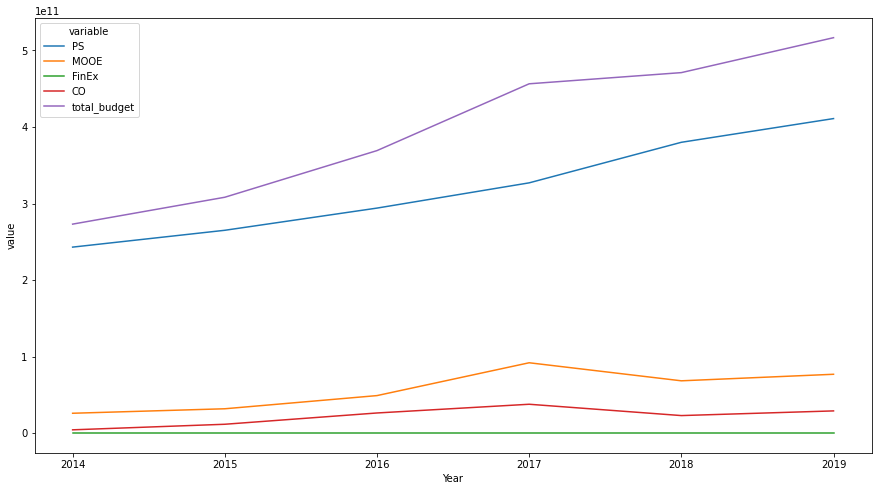

In [149]:
nep["total_budget"] = nep["PS"] + nep["MOOE"] + nep["FinEx"] + nep["CO"]
nep_melt = pd.melt(nep,id_vars="Year")

plt.figure(figsize=(15, 8))
sns.lineplot(x=r"Year", y="value", hue="variable", data=nep_melt)
plt.show()